In [212]:
from sqlalchemy import create_engine
import getpass

In [213]:
import pandas as pd
import numpy as np
import plotly.express as px

In [214]:
pd.set_option('display.max_columns',None)

In [215]:
import warnings
warnings.filterwarnings('ignore')

# 贡献率

In [216]:
def ctribtion_rate_three(df_base, df_test, x, y, x_method='sum', y_method='count', group_cols=[])->pd.DataFrame:
    """
    适用于比例类指标：考虑指标变化 + 子项样本占比变化
    case: R = 放款率 = 放款数/ 授信数 ; 放款数=安卓放款数+IOS 放款数  授信数=安卓授信数+IOS 授信数
    样本占比  P = 安卓授信数 / 授信数   S = 安卓放款数/放款数
    指标变化测算：A_i=(R_test_{ios} - R_base_{ios}) * P_base_{ios} : 假设 样本占比不变的情况下，指标变化率的贡献
    占比变化测算：B_i=(P_test_{ios}-P_base_{ios}) * (R_test_{ios} - R_base)
    总体贡献度 C_i = A_i + B_i
    diff R = R_test - R_base =  ∑C_i
    缺点
    """
    df_base[x] = pd.to_numeric(df_base[x], errors='coerce')
    df_base[y] = pd.to_numeric(df_base[y], errors='coerce')

    df_test[x] = pd.to_numeric(df_test[x], errors='coerce')
    df_test[y] = pd.to_numeric(df_test[y], errors='coerce')

    # 总的变化
    if x_method == 'sum':
        x_base_total = df_base[x].sum()
        x_test_total = df_test[x].sum()
    elif x_method == 'count':
        x_base_total = df_base[x].shape[0]
        x_test_total = df_test[x].shape[0]
    else:
        raise ValueError('x_method not support,only sum or count')

    if y_method == 'sum':
        y_base_total = df_base[y].sum()
        y_test_total = df_test[y].sum()
    elif y_method == 'count':
        y_base_total = df_base[y].shape[0]
        y_test_total = df_test[y].shape[0]
    else:
        raise ValueError('y_method not support,only sum or count')

    r = np.round(x_test_total / y_test_total - x_base_total / y_base_total, 3)

    # 维度变化
    gp_base = df_base.groupby(group_cols).agg(x_sub=(x, x_method), y_sub=(y, y_method)).reset_index()
    gp_base['r'] = np.round(gp_base.x_sub / gp_base.y_sub, 3)
    # 样本占比
    gp_base['y_over_ally'] = np.round(gp_base.y_sub / y_base_total, 3)
    gp_test = df_test.groupby(group_cols).agg(x_sub=(x, x_method), y_sub=(y, y_method)).reset_index()
    gp_test['r'] = np.round(gp_test.x_sub / gp_test.y_sub, 3)
    gp_test['y_over_ally'] = np.round(gp_test.y_sub / y_test_total, 3)

    # 合并
    gp = gp_base.merge(gp_test, on=group_cols, suffixes=('_base', '_test'), how='outer')
    gp = gp.fillna(0)
    gp['贡献率_指标变化'] = np.round((gp.r_test - gp.r_base) * gp.y_over_ally_base / r, 3)
    gp['贡献率_占比变化'] = np.round(
        (gp.y_over_ally_test - gp.y_over_ally_base) * (gp.r_test - x_base_total / y_base_total) / r, 3)
    gp['贡献率'] = gp['贡献率_指标变化'] + gp['贡献率_占比变化']
    cols = group_cols + ['x_sub_base', 'y_sub_base', 'r_base', 'y_over_ally_base', 'x_sub_test', 'y_sub_test', 'r_test',
                         'y_over_ally_test', '贡献率_指标变化', '贡献率_占比变化', '贡献率']
    gp = gp[cols]
    gp = gp.rename(columns={'x_sub_base': 'x_base', 'y_sub_base': 'y_base', 'y_over_ally_base': '占比_base','r_base':'指标_base',
                            'x_sub_test': 'x_test', 'y_sub_test': 'y_test', 'y_over_ally_test': '占比_test','r_test':'指标_test'})
    return gp

# 功能函数

In [217]:
from sklearn import metrics
def evaluate_model(y_true,y_pred):
    # auc
    # 返回 精确率，召回率，F1
    fpr, tpr, thr = metrics.roc_curve(y_true, y_pred)
    auc = np.round(metrics.roc_auc_score(y_true, y_pred), 3)
    # ks 曲线
    ks_detail = np.round(abs(tpr - fpr), 3)
    # 标注最大值
    ks_max_index = ks_detail.argmax()
    ks_max_x = fpr[ks_max_index]
    ks = ks_detail[ks_max_index]

    data = [
        # roc-auc 图
        go.Scatter(x=fpr, y=tpr, mode='lines', name='roc-auc'),
        # ks 图
        go.Scatter(x=fpr, y=ks_detail, mode='lines', name='ks'),
        # ks 最大值
        go.Scatter(x=[ks_max_x], y=[ks], name='ks-max')
    ]
    fig = go.Figure(data)
    fig.add_annotation(dict(font=dict(color='rgba(0,0,200,0.8)', size=14),
                            x=ks_max_x,
                            y=ks + 0.05,
                            showarrow=False,
                            text='ks = ' + str(ks) + '  ',
                            textangle=0,
                            xanchor='auto',
                            xref="x",
                            yref="y"))

    title = 'count:{} rate_bad:{} auc:{} ks:{} '.format(
        len(y_true), np.round(np.mean(y_true), 3),
        auc, ks
    )
    # uniformtext_minsize 调整标注文字大小；uniformtext_mode 不合规数字隐藏
    fig.update_layout(title=title, uniformtext_minsize=2, uniformtext_mode='hide')
    fig.show()

In [218]:
# 时序类函数
import datetime
def parse_month(df, date_name: str, date_name_new: str):
    """
    日期 date_name 转为新时间 date_name_new 月份
    :return: %y-%m
    """
    columns = df.columns.tolist()
    if date_name not in columns:
        raise ('not found %' % date_name)
    df[date_name] = pd.to_datetime(df[date_name])
    df[date_name_new] = df[date_name].dt.strftime('%Y-%m')
    return df


def parse_week(df: pd.DataFrame, date_name: str, date_name_new: str):
    """
    日期 date_name 转为新时间 date_name_new 周
    :return: %y-%m-%d 每周第一天
    """
    columns = df.columns.tolist()
    if date_name not in columns:
        raise ('not found %' % date_name)
    df[date_name] = pd.to_datetime(df[date_name])
    df[date_name_new] = df[date_name].dt.strftime('%w')
    df[date_name_new] = df[date_name_new].astype(int)
    df[date_name_new] = df.apply(lambda x: x[date_name] + datetime.timedelta(days=-x[date_name_new]), axis=1)
    df[date_name_new] = pd.to_datetime(df[date_name_new]).dt.date
    return df

In [219]:
# 模型分区间
def process_score(df,score_name,feature_grid):
    df[score_name] = pd.to_numeric(df[score_name],errors='coerce',downcast='float')
    # 模型分的分布
    # feature_grid=[0,0.053,0.089,0.127,0.181,0.259,1]
    df['lbl'] = pd.cut(df[score_name], feature_grid, include_lowest=True,
                               right=False, precision=4, duplicates='drop')
    df['lbl'] = df['lbl'].cat.add_categories('miss_data')
    df['lbl'] = df['lbl'].fillna('miss_data')
    df['lbl']=df['lbl'].astype(str)
    return df

In [220]:
# flag 处理
# 由于flag_name 太多，统一进行如下处理
def process_flag(df):
    df['flag_name_new']=df['order_flag_name']
    for f in ['国美','众安','小赢','好分期','分期乐','宜享花','畅行花','小安','来信','民生易贷','极融','还呗','六只羊','借掌柜','江苏树成','OPPO','360','51','上海羽习','众享花']:
        df.loc[df.order_flag_name.str.find(f)>=0,'flag_name_new']=f
    return df

In [221]:
# 划分为观察组 vs 对照组
def process_abtest(df,start_date,end_date,view_start_date,view_end_date):
    df['data_type']=None
    df.create_day=df.create_day.astype(str)
    df.loc[(df.create_day>=start_date) & (df.create_day < end_date),'data_type']='对照组'
    df.loc[(df.create_day>=view_start_date) & (df.create_day < view_end_date),'data_type']='观察组'

    df=df[df.data_type.notna()]
    return df

# 查询数据

In [222]:
def get_data(sql,engine_mysql):
    res = []
    # == palo 每次查询不超过10000
    tmp = pd.read_sql(sql, engine_mysql, chunksize=5001)
    for tt in tmp:
        res.append(tt)
    return pd.concat(res)

In [227]:
# 好会借
ip='rm-2ze12xz8uohs6j2d0.mysql.rds.aliyuncs.com'
port=3306
user_name='renpin_fengkong'
db_name='fastloan2'
passwd='sjq$uSreT7$u5jb%N4pzkNDm!$kHkE'

eng_hhj=create_engine(
            'mysql+pymysql://{user_name}:{passwd}@{ip}:{port}/{db_name}?charset=utf8'.format(
                ip=ip, port=port, user_name=user_name, passwd=passwd, db_name=db_name),
            echo=False)

In [228]:
# 助你花
ip='rm-2ze12xz8uohs6j2d0.mysql.rds.aliyuncs.com'
port=3306
user_name='renpin_fengkong'
db_name='znhv2'
passwd='sjq$uSreT7$u5jb%N4pzkNDm!$kHkE'

eng_znh=create_engine(
            'mysql+pymysql://{user_name}:{passwd}@{ip}:{port}/{db_name}?charset=utf8'.format(
                ip=ip, port=port, user_name=user_name, passwd=passwd, db_name=db_name),
            echo=False)

In [282]:
# 人品-原
ip='rr-2zey8s29rpdzme65n.mysql.rds.aliyuncs.com'
port=3306
user_name='renpin_fengkong'
db_name='rpqb'
passwd='bUEqxA2bdxgbLPsN44rFYEXdbYkzNk!!'
eng_rpqb=create_engine(
            'mysql+pymysql://{user_name}:{passwd}@{ip}:{port}/{db_name}?charset=utf8'.format(
                ip=ip, port=port, user_name=user_name, passwd=passwd, db_name=db_name),
            echo=False)

In [230]:
# # 人品-好会借实例
# ip='rm-2ze12xz8uohs6j2d0.mysql.rds.aliyuncs.com'
# port=3306
# user_name='renpin_fengkong'
# db_name='rpqb'
# passwd='sjq$uSreT7$u5jb%N4pzkNDm!$kHkE'

# eng_rpqb=create_engine(
#             'mysql+pymysql://{user_name}:{passwd}@{ip}:{port}/{db_name}?charset=utf8'.format(
#                 ip=ip, port=port, user_name=user_name, passwd=passwd, db_name=db_name),
#             echo=False)

In [231]:
# impala 链接
def get_impala_engine(ip, port, db_name, user_name, passwd):
    """
    获取impala 连接
    """
    impala_engine = create_engine(
        f'impala://{ip}:{port}/{db_name}',
        # connect_args={
        #     'auth_mechanism': 'LDAP',
        #     'user': user_name,
        #     'password': passwd
        # }
    )
    return impala_engine

engine_impala=get_impala_engine('39.107.54.36',21050,'rp_cdm',None,None)

In [232]:
sql='''
select user_id,app_order_no from rp_cdm.cdm_app2_loan_order_info_rpqb_l
where end_time='9999-12-31'
and create_time>='2023-12-13'
limit 3
'''
get_data(sql,engine_impala)

,user_id,app_order_no
0,10607392,B1673241632749715456
1,10607392,B1673241632724549632
2,10607392,B1673241632774881280


In [29]:
# # databases
# ip='rm-2ze12xz8uohs6j2d0.mysql.rds.aliyuncs.com'
# port=3306
# user_name='renpin_fengkong'
# # db_name='rpqb'
# passwd='sjq$uSreT7$u5jb%N4pzkNDm!$kHkE'

# eng_db=create_engine(
#             'mysql+pymysql://{user_name}:{passwd}@{ip}:{port}/?charset=utf8'.format(
#                 ip=ip, port=port, user_name=user_name, passwd=passwd),
#             echo=False)

In [30]:
sql='''show tables'''
# 查询数据
df_table=get_data(sql,eng_znh)
df_table.head()

,Tables_in_znhv2
0,alipay_key_record
1,alipay_key_record_copy
2,android_audit_user_info
3,api_mobile_place_info
4,apk_version_config


In [31]:
sql='''show tables'''
# 查询数据
df_table=get_data(sql,eng_rpqb)
df_table.head()

,Tables_in_rpqb
0,alipay_key_record
1,android_audit_user_info
2,api_mobile_place_info
3,app2_alipay_key_config
4,app2_alipay_key_config_s3


# 盈利

In [183]:
# 整体的测算，分为半流程 & 全流程 roi
# 数据成本 & 流量成本 
# 放款 & cps  | 授信数 *单价 | other

# 漏斗分析

In [19]:
# r1 * r2 * r3
# 准入量 -> 进件量- > 授信率 -> 申请提现率 -> 提现率 -> 放款额  -> 件均
# 整体指标 放款/进件量

In [283]:
# >= start_date  &  < end_date
start_date='2023-12-18'
end_date='2023-12-28'

In [284]:
# 恒小花 = hengshenghuo + hengxiaohuafull
sql='''
select 
  date(`create_time`) create_day,
  case when `loan_office_flag` ='baishunbao' then 'baishunbao'
    when `loan_office_flag` ='jinying' then 'jinying'
    when `loan_office_flag` ='tongcheng' then 'tongcheng'
    when `loan_office_flag` in ('hengxiaohuafull','hengshenghuo') then 'hengxiaohua'
  else 'other' end as loan_office_flag,
  sum(if(apply_status =16 and flow_status in ('1','2'),0,1)) as `准入订单量`,
  sum(if(flow_status = '6' AND apply_status = 16,1,0)) `模型分拒绝量`,
  sum(if(apply_status NOT IN (6, 7) AND flow_status NOT IN  ('1','2','6','7'),1,0)) as `进件推送量`,
  sum(if(error_status IN ('1004','1009','1010'),1,0)) as `进件失败量`,
  sum(if(apply_status in (1,2,3,9,10,11,12,13,14,15),1,0)) `授信成功量`,
  sum(if(apply_status in (1,2),1,0)) as `待提现量`,
  sum(if(apply_status in (3,9,10,11,12,13,15),1,0)) as `已提现量`,
  sum(if(apply_status =11,1,0)) as `放款中`,
  sum(if(apply_status =15,1,0)) as `放款失败`,
  sum(if(`apply_status` in (10,12,13),1,0)) `放款成功`,
  sum(if(`apply_status` in (10,12,13),convert(`loan_amount`,UNSIGNED )/100,0)) `放款额`
from `app2_loan_order_info` 
WHERE `create_time` >= '{start_date}'
  and create_time < '{end_date}'
group by 1,2;
'''.format(start_date=start_date,end_date=end_date)
print(sql)


select 
  date(`create_time`) create_day,
  case when `loan_office_flag` ='baishunbao' then 'baishunbao'
    when `loan_office_flag` ='jinying' then 'jinying'
    when `loan_office_flag` ='tongcheng' then 'tongcheng'
    when `loan_office_flag` in ('hengxiaohuafull','hengshenghuo') then 'hengxiaohua'
  else 'other' end as loan_office_flag,
  sum(if(apply_status =16 and flow_status in ('1','2'),0,1)) as `准入订单量`,
  sum(if(flow_status = '6' AND apply_status = 16,1,0)) `模型分拒绝量`,
  sum(if(apply_status NOT IN (6, 7) AND flow_status NOT IN  ('1','2','6','7'),1,0)) as `进件推送量`,
  sum(if(error_status IN ('1004','1009','1010'),1,0)) as `进件失败量`,
  sum(if(apply_status in (1,2,3,9,10,11,12,13,14,15),1,0)) `授信成功量`,
  sum(if(apply_status in (1,2),1,0)) as `待提现量`,
  sum(if(apply_status in (3,9,10,11,12,13,15),1,0)) as `已提现量`,
  sum(if(apply_status =11,1,0)) as `放款中`,
  sum(if(apply_status =15,1,0)) as `放款失败`,
  sum(if(`apply_status` in (10,12,13),1,0)) `放款成功`,
  sum(if(`apply_status` in (10,12,13),con

In [285]:
df_rpqb=get_data(sql,eng_rpqb)
df_rpqb['brand']='rpqb'
df_hhj=get_data(sql,eng_hhj)
df_hhj['brand']='hhj'
df_znh=get_data(sql,eng_znh)
df_znh['brand']='znh'

In [286]:
df_data=pd.concat([df_rpqb,df_hhj,df_znh])
df_data.shape

(150, 14)

In [287]:
# 时序函数 支持周、月，时间转换函数为  parse_month  parse_week 在功能函数可查找到
df_data=parse_month(df_data,'create_day','create_month')
df_data=parse_week(df_data,'create_day','create_week')

In [288]:
df_data.create_day=df_data.create_day.astype(str)

In [289]:
df_data.head(1)

,create_day,loan_office_flag,准入订单量,模型分拒绝量,进件推送量,进件失败量,授信成功量,待提现量,已提现量,放款中,放款失败,放款成功,放款额,brand,create_month,create_week
0,2023-12-18,baishunbao,4324.0,3149.0,1021.0,0.0,137.0,70.0,67.0,0.0,3.0,64.0,392000.0,rpqb,2023-12,2023-12-17


## 不限品牌

In [202]:
# 所有品牌汇总统计，不限制品牌

In [290]:
df_data.columns

Index(['create_day', 'loan_office_flag', '准入订单量', '模型分拒绝量', '进件推送量', '进件失败量',
       '授信成功量', '待提现量', '已提现量', '放款中', '放款失败', '放款成功', '放款额', 'brand',
       'create_month', 'create_week'],
      dtype='object')

In [291]:
cols=['准入订单量', '模型分拒绝量', '进件推送量', '进件失败量',
       '授信成功量', '待提现量', '已提现量', '放款中', '放款失败', '放款成功', '放款额']
df_sample=df_data.groupby(['create_day','loan_office_flag'])[cols].sum().reset_index()

In [292]:
df_sample['模型分拒绝率']=np.round(df_sample['模型分拒绝量']/df_sample['准入订单量'],3)
df_sample['进件成功率']=np.round((df_sample['进件推送量']-df_sample['进件失败量'])/df_sample['进件推送量'],3)
df_sample['授信成功率']=np.round(df_sample['授信成功量']/(df_sample['进件推送量']-df_sample['进件失败量']),3)
df_sample['申请提现率']=np.round(df_sample['已提现量']/df_sample['授信成功量'],3)
df_sample['放款率']=np.round(df_sample['放款成功']/df_sample['已提现量'],3)
df_sample['放款-进件率']=np.round(df_sample['放款成功']/df_sample['进件推送量'],4)
df_sample['件均']=np.round(df_sample['放款额']/df_sample['放款成功'],0)

In [293]:
# 放款-进件率 = 放款率 * 申请提现率 *  授信成功率 * 进件成功率

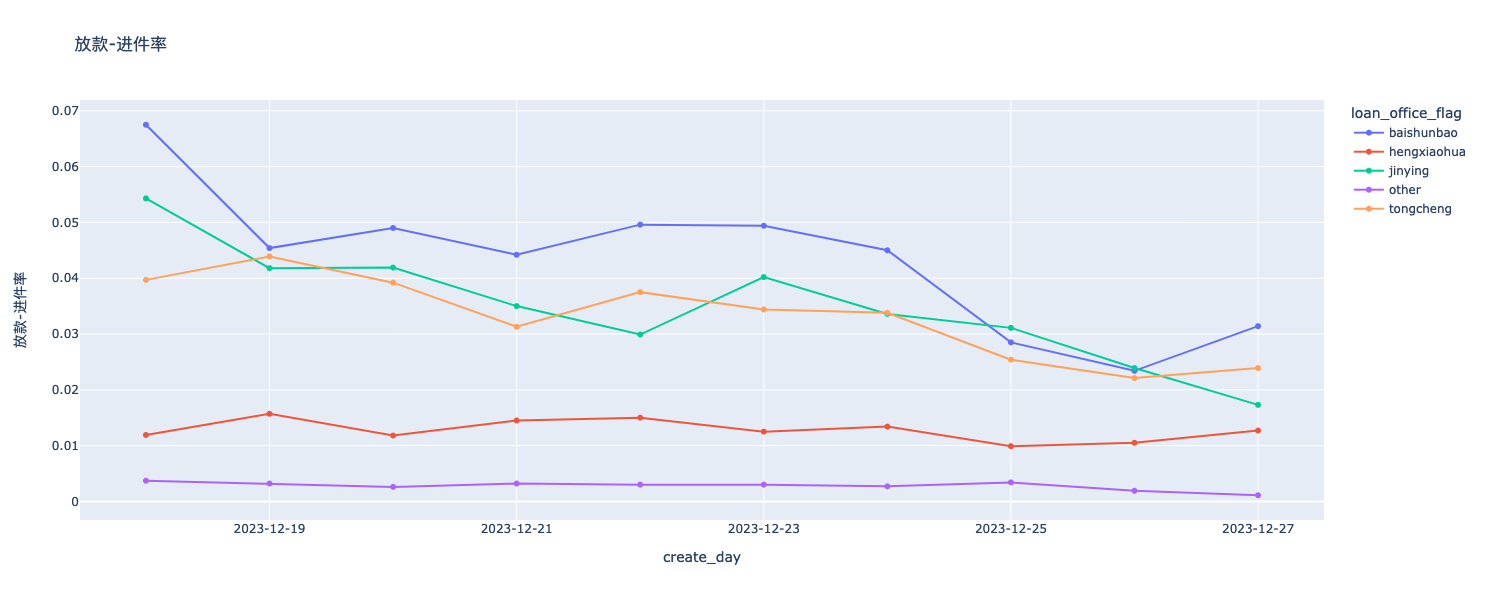

In [294]:
fig=px.line(df_sample,x='create_day',y='放款-进件率',color='loan_office_flag',markers=True,width=1000,height=1000*0.6,title='放款-进件率')
fig.update_traces(hovertemplate='<b><br>放款-进件率:%{y:.2f}%</b><BR>')
fig.update_layout(hovermode="x unified",xaxis=dict(tickformat='%Y-%m-%d'))

In [295]:
# 明细数据
df_sample[df_sample.loan_office_flag=='baishunbao']

,create_day,loan_office_flag,准入订单量,模型分拒绝量,进件推送量,进件失败量,授信成功量,待提现量,已提现量,放款中,放款失败,放款成功,放款额,模型分拒绝率,进件成功率,授信成功率,申请提现率,放款率,放款-进件率,件均
0,2023-12-18,baishunbao,7365.0,5356.0,1703.0,0.0,254.0,135.0,119.0,0.0,4.0,115.0,693000.0,0.727,1.000,0.149,0.469,0.966,0.0675,6026.0
5,2023-12-19,baishunbao,7753.0,5496.0,1981.0,0.0,232.0,136.0,96.0,0.0,6.0,90.0,652000.0,0.709,1.000,0.117,0.414,0.938,0.0454,7244.0
10,2023-12-20,baishunbao,9111.0,6638.0,2104.0,0.0,288.0,178.0,110.0,0.0,7.0,103.0,741000.0,0.729,1.000,0.137,0.382,0.936,0.0490,7194.0
15,2023-12-21,baishunbao,8192.0,6038.0,1812.0,0.0,206.0,122.0,84.0,0.0,4.0,80.0,439000.0,0.737,1.000,0.114,0.408,0.952,0.0442,5488.0
20,2023-12-22,baishunbao,8559.0,6683.0,1571.0,1.0,170.0,89.0,81.0,0.0,3.0,78.0,525000.0,0.781,0.999,0.108,0.476,0.963,0.0496,6731.0
25,2023-12-23,baishunbao,8185.0,6741.0,1134.0,0.0,129.0,73.0,56.0,0.0,0.0,56.0,461000.0,0.824,1.000,0.114,0.434,1.000,0.0494,8232.0
30,2023-12-24,baishunbao,8293.0,6805.0,1177.0,0.0,146.0,93.0,53.0,0.0,0.0,53.0,413000.0,0.821,1.000,0.124,0.363,1.000,0.0450,7792.0
35,2023-12-25,baishunbao,9195.0,6377.0,2455.0,0.0,179.0,107.0,72.0,0.0,2.0,70.0,554000.0,0.694,1.000,0.073,0.402,0.972,0.0285,7914.0
40,2023-12-26,baishunbao,6415.0,4163.0,1966.0,0.0,114.0,65.0,49.0,0.0,3.0,46.0,202000.0,0.649,1.000,0.058,0.430,0.939,0.0234,4391.0
45,2023-12-27,baishunbao,4488.0,3654.0,605.0,0.0,65.0,45.0,20.0,0.0,1.0,19.0,129000.0,0.814,1.000,0.107,0.308,0.950,0.0314,6789.0


### 按日展示某产品的指标

In [158]:
pd.pivot_table(data=df_sample,index=['loan_office_flag'],columns=['create_day'],values=['申请提现率'])

申请提现率                                              \
create_day       2023-12-18 2023-12-19 2023-12-20 2023-12-21 2023-12-22   
loan_office_flag                                                          
baishunbao            0.465      0.409      0.372      0.403      0.471   
hengxiaohua           0.412      0.539      0.517      0.602      0.500   
jinying               0.583      0.563      0.563      0.547      0.555   
other                 0.165      0.161      0.171      0.215      0.161   
tongcheng             0.144      0.163      0.142      0.142      0.148   

                                                   
create_day       2023-12-23 2023-12-24 2023-12-25  
loan_office_flag                                   
baishunbao            0.426      0.349      0.380  
hengxiaohua           0.506      0.454      0.411  
jinying               0.571      0.551      0.519  
other                 0.107      0.101      0.177  
tongcheng             0.135      0.124      0.107

## 定位指标连乘问题

In [126]:
# 放款-进件率 = 放款率 * 申请提现率 *  授信成功率 * 进件成功率

In [127]:
# 这块肉眼可见，不做数据量化处理

## 定位指标分维度分析

In [128]:
# 维度限制为 os_type,order_flag_name,loan_office_flag,brand

In [296]:
# >= start_date  &  < end_date
start_date='2023-12-10'
end_date='2023-12-28'

In [297]:
sql='''
select 
  date(`create_time`) create_day,os_type,
  case when `loan_office_flag` ='baishunbao' then 'baishunbao'
    when `loan_office_flag` ='jinying' then 'jinying'
    when `loan_office_flag` ='tongcheng' then 'tongcheng'
    when `loan_office_flag` in ('hengxiaohuafull','hengshenghuo') then 'hengxiaohua'
  else 'other' end as loan_office_flag,
  if(t2.order_flag_name is null,'unknown',t2.order_flag_name) order_flag_name,
  sum(if(apply_status =16 and flow_status in ('1','2'),0,1)) as `准入订单量`,
  sum(if(flow_status = '6' AND apply_status = 16,1,0)) `模型分拒绝量`,
  sum(if(apply_status NOT IN (6, 7) AND flow_status NOT IN  ('1','2','6','7'),1,0)) as `进件推送量`,
  sum(if(error_status IN ('1004','1009','1010'),1,0)) as `进件失败量`,
  sum(if(apply_status in (1,2,3,9,10,11,12,13,14,15),1,0)) `授信成功量`,
  sum(if(apply_status in (1,2),1,0)) as `待提现量`,
  sum(if(apply_status in (3,9,10,11,12,13,15),1,0)) as `已提现量`,
  sum(if(apply_status =11,1,0)) as `放款中`,
  sum(if(apply_status =15,1,0)) as `放款失败`,
  sum(if(`apply_status` in (10,12,13),1,0)) `放款成功`,
  sum(if(`apply_status` in (10,12,13),convert(`loan_amount`,UNSIGNED )/100,0)) `放款额`
from `app2_loan_order_info` t1 
left join (select distinct name order_flag_name,flag from `prom_company` ) t2 on t1.`order_flag` =t2.`flag` 
WHERE `create_time` >= '{start_date}'
  and create_time < '{end_date}'
group by 1,2,3,4;
'''.format(start_date=start_date,end_date=end_date)

In [298]:
df_rpqb=get_data(sql,eng_rpqb)
df_rpqb['brand']='rpqb'
df_hhj=get_data(sql,eng_hhj)
df_hhj['brand']='hhj'
df_znh=get_data(sql,eng_znh)
df_znh['brand']='znh'

In [299]:
df_data=pd.concat([df_rpqb,df_hhj,df_znh])
df_data.shape

(19446, 16)

In [300]:
# 处理 order_flag_name 
df_data=process_flag(df_data)
df_data.shape

(19446, 17)

In [301]:
df_data.head(1)

,create_day,os_type,loan_office_flag,order_flag_name,准入订单量,模型分拒绝量,进件推送量,进件失败量,授信成功量,待提现量,已提现量,放款中,放款失败,放款成功,放款额,brand,flag_name_new
0,2023-12-10,0,baishunbao,51微贷公众号,26.0,25.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rpqb,51


In [302]:
# 时序函数 支持周、月，时间转换函数为  parse_month  parse_week 在功能函数可查找到
df_data=parse_month(df_data,'create_day','create_month')
df_data=parse_week(df_data,'create_day','create_week')

In [303]:
# 维度限制为 os_type,flag_name_new,loan_office_flag,brand
# 时序 create_day  create_month  create_week
group_cols=['brand','create_day','loan_office_flag','flag_name_new']
df_sample=df_data.groupby(group_cols)[['准入订单量','模型分拒绝量','进件推送量','进件失败量','授信成功量','待提现量','已提现量','放款中','放款失败','放款成功','放款额']].sum().reset_index()

In [304]:
df_sample['进件成功量']=df_sample['进件推送量']-df_sample['进件失败量']
df_sample['模型分拒绝率']=np.round(df_sample['模型分拒绝量']/df_sample['准入订单量'],3)
df_sample['进件成功率']=np.round((df_sample['进件推送量']-df_sample['进件失败量'])/df_sample['进件推送量'],3)
df_sample['授信成功率']=np.round(df_sample['授信成功量']/(df_sample['进件推送量']-df_sample['进件失败量']),3)
df_sample['申请提现率']=np.round(df_sample['已提现量']/df_sample['授信成功量'],3)
df_sample['放款率']=np.round(df_sample['放款成功']/df_sample['已提现量'],3)
df_sample['放款-进件率']=np.round(df_sample['放款成功']/df_sample['进件推送量'],4)
df_sample['件均']=np.round(df_sample['放款额']/df_sample['放款成功'],0)

### 授信率分析

In [305]:
# 百顺宝
df_tmp=df_sample[(df_sample.loan_office_flag=='baishunbao')&(df_sample.brand=='rpqb')]

In [306]:
# 划分对照组 & 观察组
base_start_date = '2023-12-20'
base_end_date='2023-12-25'

view_start_date='2023-12-27'
view_end_date='2023-12-28'
df_tmp=process_abtest(df_tmp,base_start_date,base_end_date,view_start_date,view_end_date)

In [307]:
gp=ctribtion_rate_three(df_tmp[df_tmp.data_type=='对照组'],df_tmp[df_tmp.data_type=='观察组'],x='授信成功量',y='进件成功量',x_method='sum',y_method='sum',group_cols=['flag_name_new'])
gp=gp[gp['贡献率']>0]
gp.sort_values(['贡献率'],ascending=False)
# 贡献率 = 贡献率_指标变化 + 贡献率_占比变化[样本占比]

,flag_name_new,x_base,y_base,指标_base,占比_base,x_test,y_test,指标_test,占比_test,贡献率_指标变化,贡献率_占比变化,贡献率
22,好分期,70.0,566.0,0.124,0.106,3.0,60.0,0.050,0.141,0.327,0.096,0.423
21,国美,23.0,174.0,0.132,0.033,0.0,17.0,0.000,0.040,0.182,0.034,0.216
6,众安,149.0,966.0,0.154,0.182,8.0,55.0,0.145,0.129,0.068,0.065,0.133
20,哈啰出行,141.0,1255.0,0.112,0.236,11.0,107.0,0.103,0.251,0.089,0.008,0.097
25,小安,10.0,130.0,0.077,0.024,0.0,12.0,0.000,0.028,0.077,0.019,0.096
27,小赢,23.0,176.0,0.131,0.033,1.0,15.0,0.067,0.035,0.088,0.004,0.092
18,卡卡贷,18.0,189.0,0.095,0.036,2.0,27.0,0.074,0.063,0.032,0.047,0.079
5,众享花,20.0,110.0,0.182,0.021,1.0,10.0,0.100,0.023,0.072,0.001,0.073
52,翼支付,6.0,45.0,0.133,0.008,0.0,5.0,0.000,0.012,0.044,0.019,0.063
44,点点人品借款,32.0,188.0,0.170,0.035,3.0,24.0,0.125,0.056,0.066,-0.008,0.058


### 申请提现率分析

In [62]:
# 百顺宝
df_tmp=df_sample[df_sample.loan_office_flag=='baishunbao']

In [63]:
# 划分对照组 & 观察组
base_start_date = '2023-12-10'
base_end_date='2023-12-12'

view_start_date='2023-12-12'
view_end_date='2023-12-15'
df_tmp=process_abtest(df_tmp,base_start_date,base_end_date,view_start_date,view_end_date)

In [64]:
df_tmp.head(1)

,create_day,loan_office_flag,flag_name_new,准入订单量,模型分拒绝量,进件推送量,进件失败量,授信成功量,待提现量,已提现量,放款中,放款失败,放款成功,放款额,模型分拒绝率,进件成功率,授信成功率,申请提现率,放款率,放款-进件率,件均,进件成功量,data_type
3560,2023-12-10,baishunbao,360,1166.0,997.0,133.0,0.0,22.0,16.0,6.0,0.0,0.0,6.0,44000.0,0.855,1.0,0.165,0.273,1.0,0.0451,7333.0,133.0,对照组


In [65]:
# 申请提现率 = 已提现量/授信成功量
gp=ctribtion_rate_three(df_tmp[df_tmp.data_type=='对照组'],df_tmp[df_tmp.data_type=='观察组'],x='已提现量',y='授信成功量',x_method='sum',y_method='sum',group_cols=['flag_name_new'])
gp=gp[gp['贡献率']>0]
gp.sort_values(['贡献率'],ascending=False)
# 贡献率 = 贡献率_指标变化 + 贡献率_占比变化[样本占比]

,flag_name_new,x_base,y_base,指标_base,占比_base,x_test,y_test,指标_test,占比_test,贡献率_指标变化,贡献率_占比变化,贡献率
10,众安,35.0,81.0,0.432,0.153,19.0,78.0,0.244,0.147,0.271,-0.013,0.258
30,哈啰出行,50.0,106.0,0.472,0.201,19.0,63.0,0.302,0.119,0.322,-0.128,0.194
34,国美,7.0,9.0,0.778,0.017,2.0,11.0,0.182,0.021,0.096,0.011,0.107
8,众享花,14.0,21.0,0.667,0.040,5.0,12.0,0.417,0.023,0.094,-0.008,0.086
36,够用,8.0,9.0,0.889,0.017,6.0,15.0,0.400,0.028,0.078,0.007,0.085
87,点点人品借款,6.0,14.0,0.429,0.027,5.0,19.0,0.263,0.036,0.042,0.017,0.059
86,浩瀚钱包,5.0,6.0,0.833,0.011,1.0,4.0,0.250,0.008,0.060,-0.006,0.054
24,分期乐,1.0,1.0,1.000,0.002,8.0,22.0,0.364,0.041,0.012,0.038,0.050
99,移动白条仅联登,1.0,2.0,0.500,0.004,0.0,5.0,0.000,0.009,0.019,0.022,0.041
9,众享花uv,2.0,2.0,1.000,0.004,5.0,13.0,0.385,0.024,0.023,0.016,0.039


### 放款率分析

In [67]:
# jinying
df_tmp=df_sample[df_sample.loan_office_flag=='jinying']

In [68]:
# 划分对照组 & 观察组
base_start_date = '2023-12-10'
base_end_date='2023-12-12'

view_start_date='2023-12-12'
view_end_date='2023-12-15'
df_tmp=process_abtest(df_tmp,base_start_date,base_end_date,view_start_date,view_end_date)

In [69]:
# 放款率 = 放款成功/已提现量
gp=ctribtion_rate_three(df_tmp[df_tmp.data_type=='对照组'],df_tmp[df_tmp.data_type=='观察组'],x='放款成功',y='已提现量',x_method='sum',y_method='sum',group_cols=['flag_name_new'])
gp=gp[gp['贡献率']>0]
gp.sort_values(['贡献率'],ascending=False)
# 贡献率 = 贡献率_指标变化 + 贡献率_占比变化[样本占比]

,flag_name_new,x_base,y_base,指标_base,占比_base,x_test,y_test,指标_test,占比_test,贡献率_指标变化,贡献率_占比变化,贡献率
7,众安,57.0,697.0,0.082,0.157,43.0,708.0,0.061,0.176,0.330,0.049,0.379
28,小赢,53.0,169.0,0.314,0.038,37.0,145.0,0.255,0.036,0.224,0.034,0.258
13,分期乐,10.0,161.0,0.062,0.036,17.0,324.0,0.052,0.080,0.036,0.153,0.189
23,好分期,34.0,261.0,0.130,0.059,20.0,194.0,0.103,0.048,0.159,0.018,0.177
17,哈啰出行,77.0,879.0,0.088,0.198,69.0,867.0,0.080,0.215,0.158,0.012,0.170
47,民生易贷,7.0,73.0,0.096,0.016,1.0,52.0,0.019,0.013,0.123,-0.020,0.103
60,简单融呗,5.0,17.0,0.294,0.004,0.0,7.0,0.000,0.002,0.118,-0.017,0.101
39,有氧借,3.0,35.0,0.086,0.008,0.0,37.0,0.000,0.009,0.069,0.009,0.078
77,雪狐9（短信）,7.0,54.0,0.130,0.012,0.0,14.0,0.000,0.003,0.156,-0.078,0.078
0,360,46.0,722.0,0.064,0.163,34.0,600.0,0.057,0.149,0.114,-0.042,0.072


# 首逾

In [83]:
# 线上无法直连 ES 库，这块 hive 实现

In [181]:
# 注意数据核查，订单量放款量=还款计划表的放款量

In [ ]:
create_start_date=''

In [20]:
# 还款计划hive 中的查询sql
sql='''
select loan_office_flag,from_timestamp(loan_time,'yyyy-MM') loan_month,
    count(user_id) as cnt,
    round(avg(if(diff_days>0,1,0)),3) as fpd0,
    round(avg(if(diff_days>7,1,0)),3) as fpd7,
    round(avg(if(diff_days>15,1,0)),3) as fpd15,
    round(avg(if(diff_days>30,1,0)),3) as fpd30,
    -- jine
    round(sum(if(diff_days>0,loan_amount,0))/sum(loan_amount),3) fpd0_amt,
    round(sum(if(diff_days>7,loan_amount,0))/sum(loan_amount),3) fpd7_amt,
    round(sum(if(diff_days>15,loan_amount,0))/sum(loan_amount),3) fpd15_amt,
    round(sum(if(diff_days>30,loan_amount,0))/sum(loan_amount),3) fpd30_amt
from (
select user_id,goods_name,loan_office_flag,
    from_unixtime(cast(substring(loan_time,1,10) as int)+3600*8,'yyyy-MM-dd HH:mm:ss') loan_time,
    cast(loan_amount as int)/100 loan_amount,
    loan_give_date,actual_loan_give_date,app_loan_status,
    -- 还款日-应还日
    datediff(case when app_loan_status in ('1','2','4') then to_date(actual_loan_give_date) else to_date(now())
           end,loan_give_date) as diff_days
-- 还款计划表
from rp_cdm.dwd_rpqb_app2_loan_payment_history_es_f
where index_no='1'
-- 应还日：fpd1+
and loan_give_date < '2023-12-11'
and loan_office_flag='suiledai'
-- 放款日
and from_unixtime(cast(substring(loan_time,1,10) as int)+3600*8,'yyyy-MM-dd HH:mm:ss') < '2023-11-20'
) t
group by 1,2 order by 1,2 asc;
'''

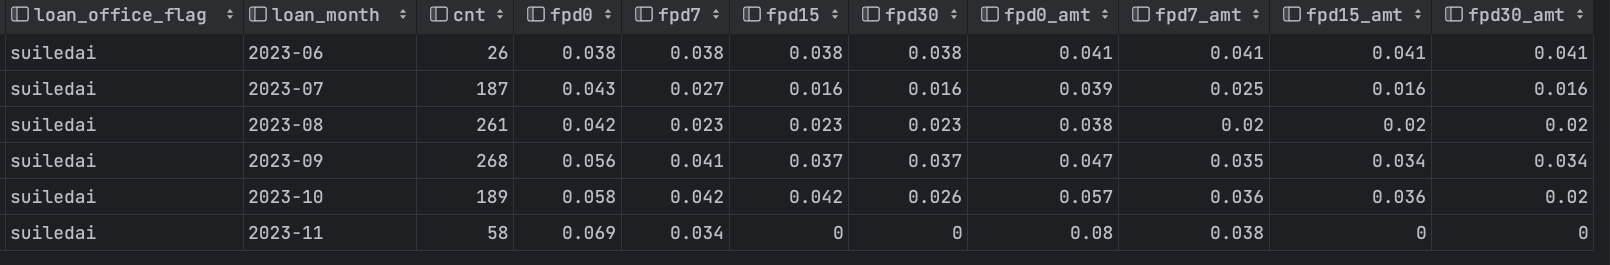

In [21]:
df_data=get_data(sql,engine_impala)
df_data.shape

(6, 11)

In [22]:
df_data

,loan_office_flag,"from_timestamp(loan_time, 'yyyy-mm')",cnt,fpd0,fpd7,fpd15,fpd30,fpd0_amt,fpd7_amt,fpd15_amt,fpd30_amt
0,suiledai,2023-06,26,0.038,0.038,0.038,0.038,0.041,0.041,0.041,0.041
1,suiledai,2023-07,187,0.043,0.027,0.016,0.016,0.039,0.025,0.016,0.016
2,suiledai,2023-08,261,0.042,0.023,0.023,0.023,0.038,0.020,0.020,0.020
3,suiledai,2023-09,268,0.056,0.041,0.037,0.037,0.047,0.035,0.034,0.034
4,suiledai,2023-10,189,0.058,0.042,0.042,0.026,0.057,0.036,0.036,0.020
5,suiledai,2023-11,58,0.069,0.034,0.000,0.000,0.080,0.038,0.000,0.000


## 首逾明细

In [64]:
loan_start_date='2023-08-01'
loan_end_date='2023-12-01'
loan_give_date='2023-12-19'
loan_office_flag='baishunbao'

In [32]:
sql='''
with flag_info as (
    select distinct name order_flag_name,flag order_flag,'rpqb' as brand from rp_ods.ods_prom_company_df
    union all
    select distinct name order_flag_name,flag order_flag,'znh' as brand from rp_ods.ods_prom_company_znh_df
    union all
    select distinct name order_flag_name,flag order_flag,'hhj' as brand from rp_ods.ods_prom_company_fastloan2_df
),loan_info as (
    -- 放款信息
    select user_id,batch_id,app_order_no,order_flag,create_time,'rpqb' as brand,os_type,
        loan_office_flag,
        from_unixtime(cast(loan_time as int)+3600*8,'yyyy-MM-dd HH:mm:ss') loan_time,
        cast(loan_amount as bigint)/100 loan_amount
    from rp_cdm.cdm_app2_loan_order_info_rpqb_l a
    where end_time='9999-12-31'
    and apply_status in (10,12,13)
    and loan_office_flag ='baishunbao'
    and  from_unixtime(cast(loan_time as int)+3600*8,'yyyy-MM-dd HH:mm:ss') > '2022-01-01'
    and from_unixtime(cast(loan_time as int)+3600*8,'yyyy-MM-dd HH:mm:ss') <'2023-12-01'
    union all

    select user_id,batch_id,app_order_no,order_flag,create_time,'hhj' as brand,os_type,
        loan_office_flag,
        from_unixtime(cast(loan_time as int)+3600*8,'yyyy-MM-dd HH:mm:ss') loan_time,
        cast(loan_amount as bigint)/100 loan_amount
    from rp_cdm.cdm_app2_loan_order_info_fastloan2_l
    where end_time='9999-12-31'
    and apply_status in (10,12,13)
    and loan_office_flag='baishunbao'
    and  create_time > '2022-01-01'
    and create_time <'2023-12-01'
    union all
    --
    select user_id,batch_id,app_order_no,order_flag,create_time,'znh' as brand,os_type,
        loan_office_flag,
        from_unixtime(cast(loan_time as int)+3600*8,'yyyy-MM-dd HH:mm:ss') loan_time,
        cast(loan_amount as bigint)/100 loan_amount
    from rp_cdm.cdm_app2_loan_order_info_znh_l
    where end_time='9999-12-31'
    and apply_status in (10,12,13)
    and loan_office_flag='baishunbao'
    and create_time > '2022-01-01'
    and create_time <'2023-12-01'
),repay_info as (
select user_id,brand,order_no,app_loan_status,loan_office_status,
    to_date(loan_give_date) loan_give_date,to_date(actual_loan_give_date) actual_loan_give_date
from rp_cdm.dwd_rpqb_app2_loan_payment_history_es_f
where index_no='1'
and from_unixtime(cast(substring(loan_time,1,10) as int)+3600*8,'yyyy-MM-dd HH:mm:ss') > '2022-01-01'
and from_unixtime(cast(substring(loan_time,1,10) as int)+3600*8,'yyyy-MM-dd HH:mm:ss') < '2023-11-19'
and loan_office_flag ='baishunbao'
and loan_give_date < '2023-12-19'
)
select t1.*,t3.app_loan_status,t3.loan_office_status,t3.loan_give_date,t3.actual_loan_give_date,
       t4.order_flag_name
from loan_info t1
join repay_info t3 on t1.app_order_no=t3.order_no and t1.brand=t3.brand
left join flag_info t4 on t1.order_flag=t4.order_flag and t1.brand=t4.brand
'''

# 模型分分布

## 授信分

In [193]:
# 表中的模型分只有200状态的，非200状态的不存储

In [257]:
# >=start_date & < end_date
start_date='2023-12-20'
end_date='2023-12-28'

In [258]:
sql='''
select a.*,b.order_flag_name from (
  select user_id,app_order_no,`product_key` ,`channel_flag` ,`result_module_result` model_score ,`create_day` 
  from `user_module_record_info` 
  where `result_module_code` ='br_credit_v1'
  and `create_time` >='{start_date}'
  and `create_time` <'{end_date}'
  group by 1,2,3,4
) a 
join (
select distinct name order_flag_name,flag from prom_company 
) b on a.channel_flag=b.flag
'''.format(start_date=start_date,end_date=end_date)
print(sql)


select a.*,b.order_flag_name from (
  select user_id,app_order_no,`product_key` ,`channel_flag` ,`result_module_result` model_score ,`create_day` 
  from `user_module_record_info` 
  where `result_module_code` ='br_credit_v1'
  and `create_time` >='2023-12-20'
  and `create_time` <'2023-12-28'
  group by 1,2,3,4
) a 
join (
select distinct name order_flag_name,flag from prom_company 
) b on a.channel_flag=b.flag



In [259]:
df_hhj=get_data(sql,eng_hhj)
df_hhj['brand']='hhj'

df_rpqb=get_data(sql,eng_rpqb)
df_rpqb['brand']='rqpb'

df_znh=get_data(sql,eng_znh)
df_znh['brand']='znh'

df_data=pd.concat([df_hhj,df_rpqb,df_znh])
df_data.shape

(74592, 8)

In [260]:
df_data.create_day=df_data.create_day.astype(str)
# 时序函数 支持周、月，时间转换函数为  parse_month  parse_week 在功能函数可查找到
df_data=parse_month(df_data,'create_day','create_month')
df_data=parse_week(df_data,'create_day','create_week')

In [261]:
# 划分区间
feature_grid=[0,0.043,0.061,0.089,0.127,0.181,0.259,1]
df_data=process_score(df_data,'model_score',feature_grid)

In [262]:
# order_flag
df_data=process_flag(df_data)

In [263]:
df_data.head(1)

,user_id,app_order_no,product_key,channel_flag,model_score,create_day,order_flag_name,brand,create_month,create_week,lbl,flag_name_new
0,100443,B1737756917454282756,haluo,f38558df295b4aa1a4e6061f6f3ab284,0.243726,2023-12-21,融360,hhj,2023-12,2023-12-17,"[0.181, 0.259)",360


### 整体分布

In [264]:
df_sample=df_data.drop_duplicates(['user_id','create_day','brand'])

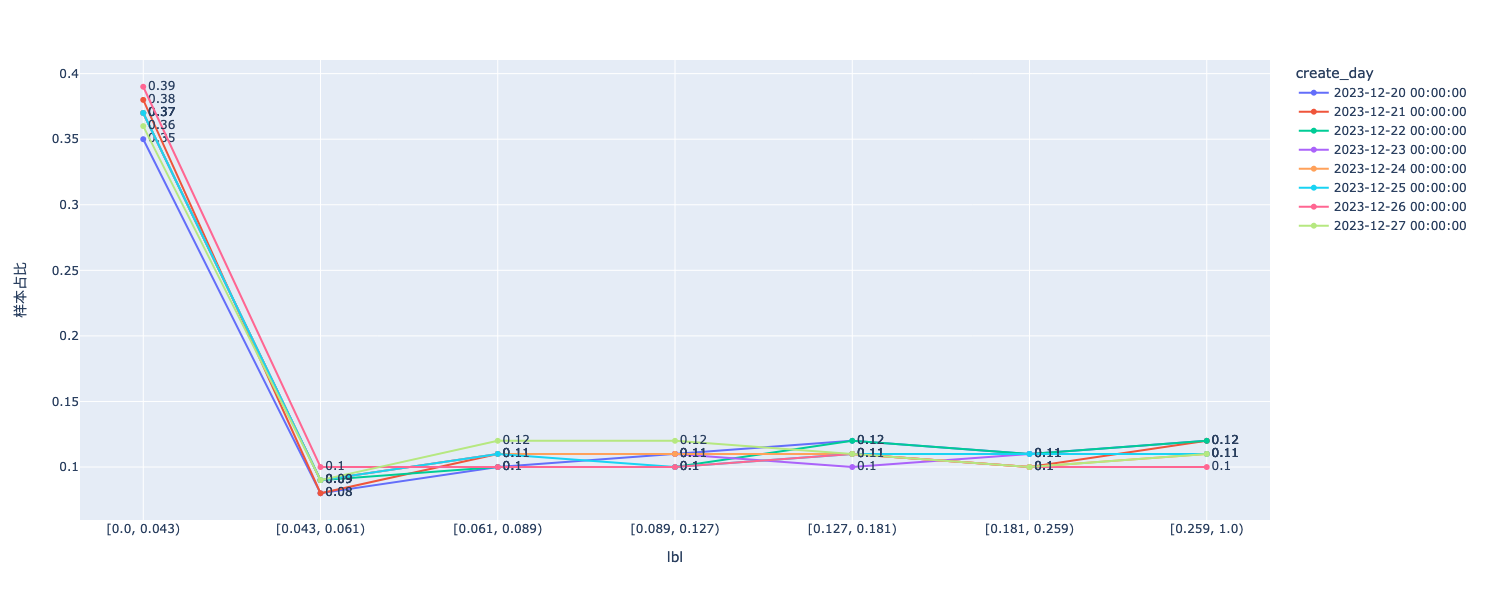

In [265]:
gp = df_sample.groupby(['create_day','lbl']).agg(cnt=('user_id','nunique')).reset_index()
t = df_sample.groupby(['create_day']).agg(cnt_all=('user_id','nunique')).reset_index()
gp=gp.merge(t,on=['create_day'],how='left')
gp['样本占比']=np.round(gp.cnt/gp.cnt_all,2)
fig=px.line(gp,x='lbl',y='样本占比',color='create_day',markers=True,text='样本占比',
        hover_data=['create_day','lbl','cnt','cnt_all','样本占比',],width=1000,height=1000*0.6)
fig.update_traces(textposition='middle right')
fig.update_layout(hovermode="x unified")

### 分产品看分布

In [266]:
df_sample=df_data.copy()

In [267]:
gp = df_sample.groupby(['create_day','product_key','lbl']).agg(cnt=('user_id','nunique')).reset_index()
t = df_sample.groupby(['create_day','product_key']).agg(cnt_all=('user_id','nunique')).reset_index()
gp=gp.merge(t,on=['create_day','product_key'],how='left')
gp['样本占比']=np.round(gp.cnt/gp.cnt_all,2)

In [268]:
gp.head(1)

,create_day,product_key,lbl,cnt,cnt_all,样本占比
0,2023-12-20,baishunbao,"[0.0, 0.043)",979,3057,0.32


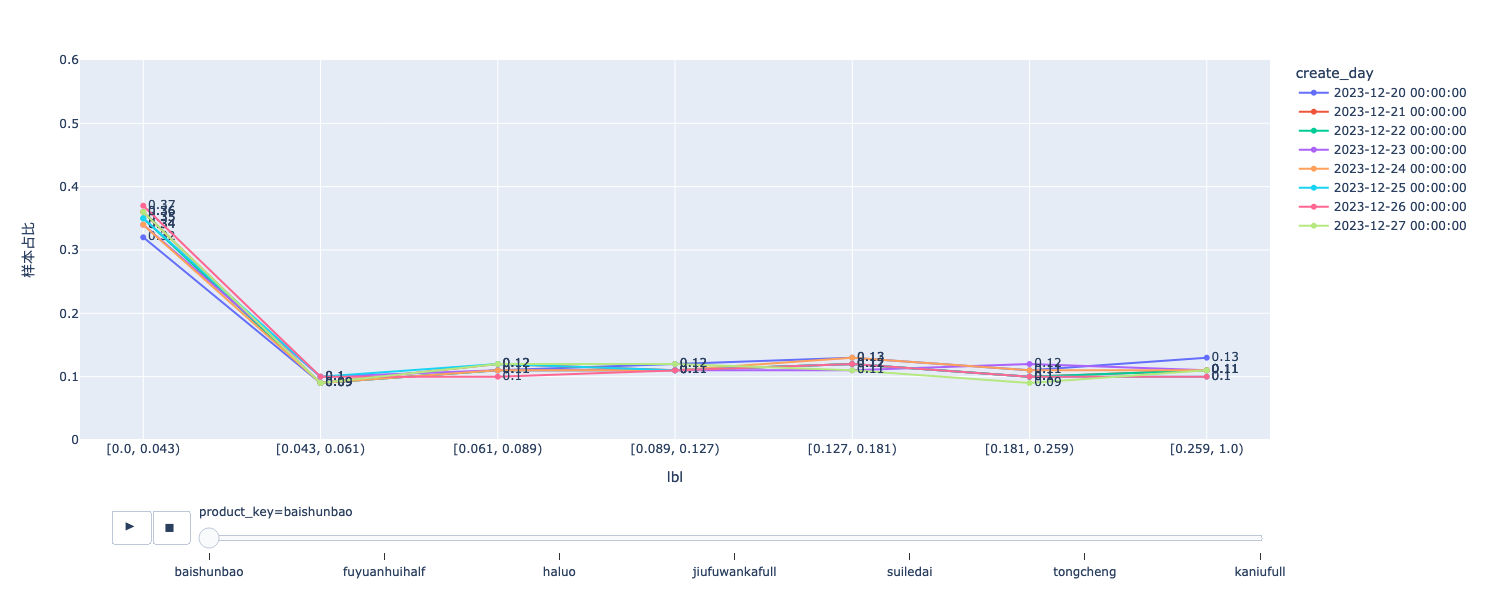

In [269]:
fig=px.line(gp,x='lbl',y='样本占比',color='create_day',markers=True,text='样本占比',animation_frame='product_key',
        hover_data=['create_day','lbl','cnt','cnt_all','样本占比',],width=1000,height=1000*0.6,range_y=(0,0.6))
fig.update_traces(textposition='middle right')
fig.update_layout(hovermode="x unified")

### 分流量看分布

In [270]:
df_data.user_id.value_counts()[:2]

user_id
18983038    7
18984638    7
Name: count, dtype: int64

In [271]:
df_sample=df_data.drop_duplicates(['user_id','brand','create_day'])

In [276]:
df_sample.head(1)

,user_id,app_order_no,product_key,channel_flag,model_score,create_day,order_flag_name,brand,create_month,create_week,lbl,flag_name_new
0,100443,B1737756917454282756,haluo,f38558df295b4aa1a4e6061f6f3ab284,0.243726,2023-12-21,融360,hhj,2023-12,2023-12-17,"[0.181, 0.259)",360


In [277]:
df_sample=df_sample[df_sample.product_key=='baishunbao']

In [278]:
gp = df_sample.groupby(['create_day','flag_name_new','lbl']).agg(cnt=('user_id','nunique')).reset_index()
t = df_sample.groupby(['create_day','flag_name_new']).agg(cnt_all=('user_id','nunique')).reset_index()
gp=gp.merge(t,on=['create_day','flag_name_new'],how='left')
gp['样本占比']=np.round(gp.cnt/gp.cnt_all,2)

In [281]:
df_sample.flag_name_new.value_counts()[:20]

flag_name_new
360         2091
众享花         2043
小赢          1436
众安          1358
畅行花          989
极用           730
51           729
借用钱          369
牛牛花          355
民生易贷         347
还呗           304
自然量渠道        293
宜享花          263
雪狐15（短信）     194
有氧借          194
水滴融          183
同程金融         182
够用           163
OPPO         147
白白贷款         141
Name: count, dtype: int64

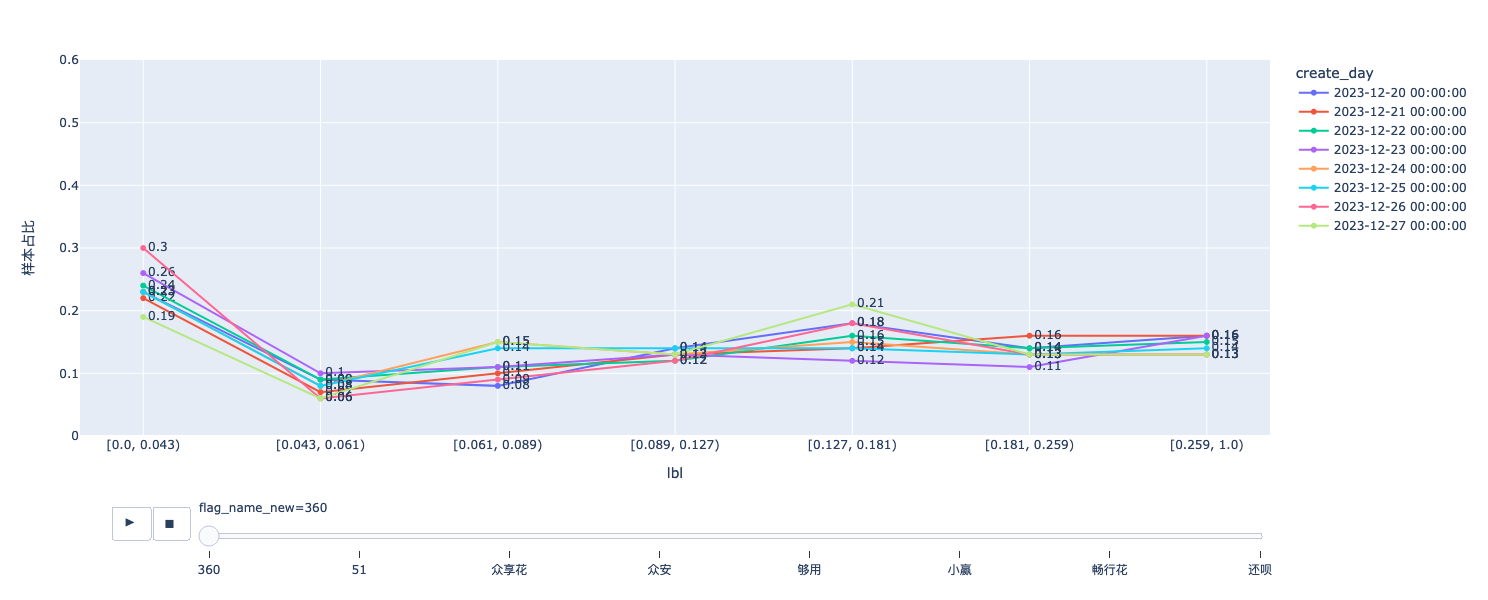

In [280]:
flag_name_news=['360','够用','小赢','众享花','众安','畅行花','还呗','51']
fig=px.line(gp[gp.flag_name_new.isin(flag_name_news)],x='lbl',y='样本占比',color='create_day',markers=True,text='样本占比',animation_frame='flag_name_new',
        hover_data=['create_day','lbl','cnt','cnt_all','样本占比',],width=1000,height=1000*0.6,range_y=(0,0.6))
fig.update_traces(textposition='middle right')
fig.update_layout(hovermode="x unified")

### 授信分同授信率关系

In [127]:
# 只针对打了模型分的,
# 限制产品，因为查询详情慢

In [125]:
start_date='2023-12-21'
end_date='2023-12-26'
loan_office_flag='baishunbao'

In [126]:
sql='''
select a.*,b.os_type,
  if(c.order_flag_name is null,'unknown',c.order_flag_name) order_flag_name,
  `是否准入`,`是否拒绝`,`是否进件`,`是否进件失败`,`是否授信`, `是否取消借款`,`是否已提现`,`是否放款`,loan_time,loan_amount
from (
select user_id,`app_order_no` ,`channel_flag` ,`result_module_result`  model_score,`create_day`
from `user_module_record_info` 
where `result_module_code` ='br_credit_v1'
and `create_time` >='{start_date}'
and `create_time` <'{end_date}'
and product_key='{loan_office_flag}'
) a 
  JOIN (
  select `app_order_no`,os_type,
  if(apply_status =16 and flow_status in ('1','2'),0,1) `是否准入`,
  -- 不一定是授信分拒绝，当前只有授信模型，故这样写
  if(flow_status = '6' AND apply_status = 16,1,0) `是否拒绝`,
  if(apply_status NOT IN (6, 7) AND flow_status NOT IN  ('1','2','6','7'),1,0) `是否进件`,
  if(error_status IN ('1004','1009','1010'),1,0) `是否进件失败`,
  if(apply_status in (1,2,3,9,10,11,12,13,14,15),1,0) `是否授信`,
  if(apply_status=14,1,0) `是否取消借款`,
  if(apply_status in (3,9,10,11,12,13,15),1,0) `是否已提现`,
  if(`apply_status` in (10,12,13),1,0) `是否放款`,
  if(`apply_status` in (10,12,13),from_unixtime(convert(substring(loan_time,1,10),UNSIGNED ) + 3600*8,'%%Y-%%m-%%d'),NULL ) loan_time,
  if(`apply_status` in (10,12,13),CONVERT(`loan_amount` ,UNSIGNED )/100,0) loan_amount
from `app2_loan_order_info` 
WHERE `create_time` >='{start_date}'
and `create_time` <'{end_date}'
and loan_office_flag='{loan_office_flag}'
) b on a.`app_order_no` =b.app_order_no
left join (
 select distinct name order_flag_name,flag from prom_company
) c on a.channel_flag=c.flag
'''.format(start_date=start_date,end_date=end_date,loan_office_flag=loan_office_flag)
print(sql)


select a.*,b.os_type,
  if(c.order_flag_name is null,'unknown',c.order_flag_name) order_flag_name,
  `是否准入`,`是否拒绝`,`是否进件`,`是否进件失败`,`是否授信`, `是否取消借款`,`是否已提现`,`是否放款`,loan_time,loan_amount
from (
select user_id,`app_order_no` ,`channel_flag` ,`result_module_result`  model_score,`create_day`
from `user_module_record_info` 
where `result_module_code` ='br_credit_v1'
and `create_time` >='2023-12-21'
and `create_time` <'2023-12-26'
and product_key='baishunbao'
) a 
  JOIN (
  select `app_order_no`,os_type,
  if(apply_status =16 and flow_status in ('1','2'),0,1) `是否准入`,
  -- 不一定是授信分拒绝，当前只有授信模型，故这样写
  if(flow_status = '6' AND apply_status = 16,1,0) `是否拒绝`,
  if(apply_status NOT IN (6, 7) AND flow_status NOT IN  ('1','2','6','7'),1,0) `是否进件`,
  if(error_status IN ('1004','1009','1010'),1,0) `是否进件失败`,
  if(apply_status in (1,2,3,9,10,11,12,13,14,15),1,0) `是否授信`,
  if(apply_status=14,1,0) `是否取消借款`,
  if(apply_status in (3,9,10,11,12,13,15),1,0) `是否已提现`,
  if(`apply_status` in (10,12,13),1,0) `是否放款

In [127]:
df_hhj=get_data(sql,eng_hhj)
df_hhj['brand']='hhj'

df_rpqb=get_data(sql,eng_rpqb)
df_rpqb['brand']='rqpb'

df_znh=get_data(sql,eng_znh)
df_znh['brand']='znh'

df_data=pd.concat([df_hhj,df_rpqb,df_znh])
df_data.shape

(16275, 18)

In [128]:
df_data.head(1)

,user_id,app_order_no,channel_flag,model_score,create_day,os_type,order_flag_name,是否准入,是否拒绝,是否进件,是否进件失败,是否授信,是否取消借款,是否已提现,是否放款,loan_time,loan_amount,brand
0,18467049,B1737503204043726852,400bcde6cda446b1bd2d4723946b0d2e,0.189046,2023-12-21,1,360借条,1,0,1,0,0,0,0,0,None,0.0,hhj


In [129]:
# 划分区间
feature_grid=[0,0.043,0.061,0.089,0.127,0.181,0.259,1]
df_data=process_score(df_data,'model_score',feature_grid)

In [130]:
df_data=process_flag(df_data)

In [131]:
# 剔除模型拒绝的数据
df_data=df_data[df_data['是否拒绝']==0]
df_data.shape

(2348, 20)

In [132]:
# auc 
evaluate_model(df_data['是否授信'],df_data['model_score'])

ValueError: unknown format is not supported

In [133]:
# 
df_sample=df_data.groupby(['create_day','lbl']).agg(
 进件成功量=('是否进件','sum'),授信量=('是否授信','sum'),已提现量=('是否已提现','sum'),放款量=('是否放款','sum'),放款额=('loan_amount','sum')
).reset_index()
df_sample['授信量']=df_sample['授信量'].astype(int)
df_sample['进件成功量']=df_sample['进件成功量'].astype(int)
df_sample['授信率']=np.round(df_sample['授信量']/df_sample['进件成功量'],3)

In [134]:
df_sample.head()

,create_day,lbl,进件成功量,授信量,已提现量,放款量,放款额,授信率
0,2023-12-21,"[0.181, 0.259)",268,38,16,15,58000.0,0.142
1,2023-12-21,"[0.259, 1.0)",338,52,27,27,161000.0,0.154
2,2023-12-22,"[0.181, 0.259)",129,14,8,8,36000.0,0.109
3,2023-12-22,"[0.259, 1.0)",390,42,23,21,188000.0,0.108
4,2023-12-23,"[0.259, 1.0)",334,39,13,13,89000.0,0.117


## A卡

In [126]:
# 流程同 授信分一致，参数改为 A卡 br_acard_v1即可

In [ ]:
# A卡同贷后的关系，在hive 中实现

In [ ]:
feature_grid=[0,0.033,0.038,0.043,0.052,0.074,1]

In [ ]:
fig=px.histogram(df_data,x='lbl',color='create_month',barmode='group',nbins=20,
            histnorm='percent')
fig.update_layout(
  xaxis=dict(categoryorder='array',
             categoryarray=['[0.0, 0.033)', '[0.033, 0.038)','[0.038, 0.043)','[0.043, 0.052)', 
                                               '[0.052, 0.074)', '[0.074, 1.0)', 'miss_data']
            )
)
fig.show()

## 模型特征关系

In [176]:
# 这块线上数据无法使用，未做解析，当前使用hive进行线下分析，目前hive 开发三方数据大宽表中

# 专题分析

## 百顺宝拒绝原因

In [376]:
sql='''
select `create_day` ,`loan_office_status` ,count(1) cnt
  from `app2_loan_order_info` where create_time>'2023-11-02'
and `loan_office_flag` ='baishunbao'
and `error_status` !='6001'
and CONVERT(`flow_status` ,UNSIGNED )>2
and `apply_status` not in (6,7)
group by 1,2;
'''

In [377]:
df_data=get_data(sql,eng_rpqb)

In [378]:
t=df_data.groupby('create_day').cnt.sum().reset_index()
df_data=df_data.merge(t,on='create_day',how='left',suffixes=('','_all'))
df_data['拒绝占比']=np.round(df_data.cnt/df_data.cnt_all,2)

In [379]:
df_data.loan_office_status.unique()

array(['', '命中多头', '综合评分不足', '黑名单', '系统异常', '参数异常'], dtype=object)

In [385]:
df_data[df_data.loan_office_status=='综合评分不足']

,create_day,loan_office_status,cnt,cnt_all,拒绝占比
2,2023-11-02,综合评分不足,646,804,0.80
6,2023-11-03,综合评分不足,633,803,0.79
10,2023-11-04,综合评分不足,644,805,0.80
14,2023-11-05,综合评分不足,637,805,0.79
18,2023-11-06,综合评分不足,630,807,0.78
22,2023-11-07,综合评分不足,638,808,0.79
26,2023-11-08,综合评分不足,636,808,0.79
31,2023-11-09,综合评分不足,715,905,0.79
35,2023-11-10,综合评分不足,687,906,0.76
40,2023-11-11,综合评分不足,679,903,0.75
